In [0]:
# # required if saving files to drive
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# # required if running on Colab
# !pip install jiwer

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import os
import re
import json
import time

import random
import numpy as np
from jiwer import wer
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder

from IPython.display import Image

from seq_seq_same import Seq2SeqSame

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SEED = 1
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Common parameters

In [0]:
batch_size = 32
split_ratio = 0.8
learning_rate = 0.001

# Loading bAbi

In [9]:
from babi import babiDataset

task = 2

babi = babiDataset(task=task, split_ratio=split_ratio, device=device, seed=SEED)
babi.load(verbose=True)
train_loader, valid_loader, test_loader = babi.create_data_loader(batch_size)

Cannot find dataset in path .data. Downloading dataset...
Training data size:    8000
Validation data size:  2000
Test data size:        1000


# LSTM

### Our implementation

In [17]:
# Input dim
input_dim = babi.max_vocab_size
# Number of hidden nodes
hidden_dim = 256
# Number of output nodes
output_dim = babi.max_vocab_size
# Number of LSTMs cells to be stacked
layers = 1
# Boolean value for bidirectioanl or not
bidirectional = True
# Boolean value to use LayerNorm or not
layernorm = True

from seq_seq_same import LSTMSeq2SeqSame

our = LSTMSeq2SeqSame(input_dim=input_dim, hidden_dim=hidden_dim, 
                      output_dim=output_dim, layers=layers, 
                      bidirectional=bidirectional, layernorm=layernorm).to(device)

print("Our implementation\n{}".format("=" * len("Our implementation")))
print("# of parameters: {}".format(our.count_parameters()))
for name, param in our.named_parameters():
    print("{:<40}: {}".format(name, param.shape))

Our implementation
# of parameters: 623652
lstm.model.0.weights                    : torch.Size([292, 1024])
lstm.model.0.bias                       : torch.Size([1024])
lstm.model.0.ln_gates.weight            : torch.Size([1024])
lstm.model.0.ln_gates.bias              : torch.Size([1024])
lstm.model.0.ln_candidate.weight        : torch.Size([256])
lstm.model.0.ln_candidate.bias          : torch.Size([256])
lstm.model_rev.0.weights                : torch.Size([292, 1024])
lstm.model_rev.0.bias                   : torch.Size([1024])
lstm.model_rev.0.ln_gates.weight        : torch.Size([1024])
lstm.model_rev.0.ln_gates.bias          : torch.Size([1024])
lstm.model_rev.0.ln_candidate.weight    : torch.Size([256])
lstm.model_rev.0.ln_candidate.bias      : torch.Size([256])
fc.weight                               : torch.Size([36, 512])
fc.bias                                 : torch.Size([36])


In [0]:
from seq_seq_same import Seq2SeqSame

loss_fn = nn.CrossEntropyLoss()
optimizer_our = torch.optim.Adam(our.parameters(), lr=learning_rate)

task_our = Seq2SeqSame(our, optimizer_our, loss_fn, device)
out_dir = '/content/drive/My Drive/colab/hpo/seq_seq_same/600k/LSTM/'

### Train

Beginning training model with 623652 parameters
Files will be saved in: /content/drive/My Drive/colab/hpo/seq_seq_same/LSTM/


Epoch #1: Average loss is 0.5201616888716817
Epoch #1: Train WER is 1.0
Epoch #1: Validation WER is 1.0
Time taken for epoch: 442.5733368396759s


Epoch #2: Average loss is 0.018875388357788323
Time taken for epoch: 318.25512313842773s


Epoch #3: Average loss is 0.013311000991612672
Time taken for epoch: 317.86557602882385s


Epoch #4: Average loss is 0.01247214874625206
Time taken for epoch: 318.822562456131s


Epoch #5: Average loss is 0.011960056997835635
Epoch #5: Train WER is 0.7905532163255097
Epoch #5: Validation WER is 0.7779810410776651
Time taken for epoch: 444.9254057407379s


Epoch #6: Average loss is 0.011427659494802355
Time taken for epoch: 319.81431913375854s


Epoch #7: Average loss is 0.010686147525906563
Time taken for epoch: 320.43465518951416s


Epoch #8: Average loss is 0.012547840386629105
Time taken for epoch: 320.47028374671936s


Epoc

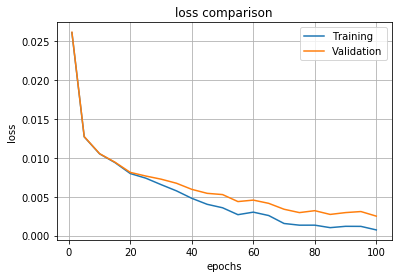

In [0]:
our, our_stats = task_our.train(epochs=100, train_loader=train_loader, valid_loader=valid_loader, 
                                out_dir=out_dir, freq=5, vocab=babi.vocab, wer_dict=babi.wer_dict)

### Evaluate

In [0]:
# # To test a saved model
# task_our.model.load(os.path.join(out_dir, 'model_epoch_20.pkl'))

In [22]:
our_wer, _ = task_our.evaluate(test_loader, babi.vocab, babi.wer_dict, 
                               verbose=True)
print(our_wer)

Confusion Matrix: 
 [[196  41  96  83  40  54]
 [ 53 261  70  70  42  11]
 [ 55  36 239  70  50  31]
 [ 50  64  47 338  24  32]
 [ 69  34  64  69 188  46]
 [ 42  57  93  70  24 191]]

Classification Report: 
               precision    recall  f1-score   support

           7       0.42      0.38      0.40       510
          10       0.53      0.51      0.52       507
          16       0.39      0.50      0.44       481
          18       0.48      0.61      0.54       555
          21       0.51      0.40      0.45       470
          22       0.52      0.40      0.45       477

    accuracy                           0.47      3000
   macro avg       0.48      0.47      0.47      3000
weighted avg       0.48      0.47      0.47      3000

0.529


# Transformer

### Our implementation

In [24]:
from seq_seq_same import TransformerSeq2SeqSame

# create model
model = TransformerSeq2SeqSame(in_dim=babi.max_vocab_size, 
                               out_dim=babi.max_vocab_size, N=1, heads=5, 
                               model_dim=256, key_dim=64, value_dim=64, 
                               ff_dim=512, batch_first=False)
model = model.to(device)

print("Our implementation\n{}".format("=" * len("Our implementation")))
print("# of parameters: {}".format(model.count_parameters()))
for name, param in model.named_parameters():
    print("{:<45}: {}".format(name, param.shape))

Our implementation
# of parameters: 611556
embed.weight                                 : torch.Size([256, 36])
embed.bias                                   : torch.Size([256])
encoder.enc_stack.0.self_attn.Wq.weight      : torch.Size([320, 256])
encoder.enc_stack.0.self_attn.Wq.bias        : torch.Size([320])
encoder.enc_stack.0.self_attn.Wk.weight      : torch.Size([320, 256])
encoder.enc_stack.0.self_attn.Wk.bias        : torch.Size([320])
encoder.enc_stack.0.self_attn.Wv.weight      : torch.Size([320, 256])
encoder.enc_stack.0.self_attn.Wv.bias        : torch.Size([320])
encoder.enc_stack.0.self_attn.Wout.weight    : torch.Size([256, 320])
encoder.enc_stack.0.self_attn.Wout.bias      : torch.Size([256])
encoder.enc_stack.0.self_attn.norm.weight    : torch.Size([256])
encoder.enc_stack.0.self_attn.norm.bias      : torch.Size([256])
encoder.enc_stack.0.pos_ff.w1.weight         : torch.Size([512, 256])
encoder.enc_stack.0.pos_ff.w1.bias           : torch.Size([512])
encoder.enc_stack.

In [0]:
from seq_seq_same import Seq2SeqSame
from transformer import NoamOpt

loss_fn = nn.CrossEntropyLoss()
optimizer = NoamOpt(model.model_dim, 1, 2000,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

task = Seq2SeqSame(model, optimizer, loss_fn, device)
out_dir = '/content/drive/My Drive/colab/hpo/seq_seq_same/Transformer/'

### Train

Beginning training model with 611556 parameters
Files will be saved in: /content/drive/My Drive/colab/hpo/seq_seq_same/Transformer/


Epoch #1: Average loss is 0.4138970923349261
Epoch #1: Train WER is 0.9701088089381749
Epoch #1: Validation WER is 0.969732246798603
Time taken for epoch: 19.555157899856567s


Epoch #2: Average loss is 0.01584042953327298
Time taken for epoch: 12.846841812133789s


Epoch #3: Average loss is 0.012465684708207846
Time taken for epoch: 12.74396300315857s


Epoch #4: Average loss is 0.012291702281683683
Time taken for epoch: 12.733456373214722s


Epoch #5: Average loss is 0.011478444248437882
Epoch #5: Train WER is 0.6132071538750157
Epoch #5: Validation WER is 0.6336271411940795
Time taken for epoch: 19.17682123184204s


Epoch #6: Average loss is 0.010191586278378963
Time taken for epoch: 12.794219732284546s


Epoch #7: Average loss is 0.009844736713916063
Time taken for epoch: 12.843068838119507s


Epoch #8: Average loss is 0.009694523585960268
Time taken

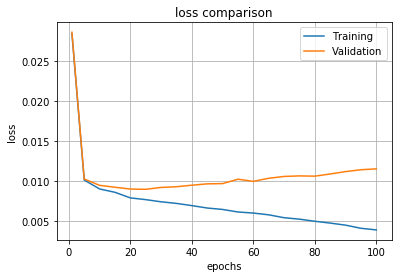

In [0]:
model, stats = task.train(epochs=100, train_loader=train_loader, valid_loader=valid_loader, 
                                            out_dir=out_dir, freq=5, vocab=babi.vocab, 
                                            wer_dict=babi.wer_dict)

### Evaluate

In [0]:
# # To test a saved model
# task_our.model.load(os.path.join(out_dir, 'model_epoch_20.pkl'))

In [0]:
transformer_wer, _ = task.evaluate(test_loader, babi.vocab, babi.wer_dict, verbose=True)
print(transformer_wer)

Confusion Matrix: 
 [[  0   0   0   0   0   0   0]
 [ 73 121  46  70  10  14 176]
 [ 80  81  90  65  13  17 161]
 [ 83  71  30 118   9  24 146]
 [ 96  64  26  71  42  35 221]
 [ 72  47  37  81  20  35 178]
 [ 86  28  19  43  11  14 276]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           7       0.29      0.24      0.26       510
          10       0.36      0.18      0.24       507
          16       0.26      0.25      0.25       481
          18       0.40      0.08      0.13       555
          21       0.25      0.07      0.11       470
          22       0.24      0.58      0.34       477

    accuracy                           0.23      3000
   macro avg       0.26      0.20      0.19      3000
weighted avg       0.30      0.23      0.22      3000

0.7726666666666666


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
